In [1]:
import os
import sys
import re
import json
from time import monotonic
from datetime import datetime
from collections import OrderedDict
from typing import List, NamedTuple

import numpy as np
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.path.abspath('../code'))
from translation_dataset import *

In [2]:
data_root_dir = '../data'
assert os.path.isdir(data_root_dir)

common_path_prefix = data_root_dir + '/ParallelEnRu/OpenSubtitlesv2018/en-ru-rev-norm'
train_path_prefix = common_path_prefix + '-train'
dev_path_prefix   = common_path_prefix + '-dev'

train_bpe_en_path          = train_path_prefix + '-bpe-40k-en.txt'
train_bpe_ru_path          = train_path_prefix + '-bpe-40k-ru.txt'
train_vocab_en_path        = train_path_prefix + '-bpe-40k-vocab-en.txt'
train_vocab_ru_path        = train_path_prefix + '-bpe-40k-vocab-ru.txt'
train_dataset_tok_ids_path = train_path_prefix + '-bpe-40k-tok-ids.txt'

dev_dataset_tok_ids_path = dev_path_prefix + '-bpe-40k-tok-ids.txt'
dev_dataset_toks_path    = dev_path_prefix + '-bpe-40k-toks.txt'
    

songs_dataset_path_prefix = data_root_dir + '/ParallelEnRu/Songs' + \
                               '/songs-adj-en-ru-lines-rev-norm'
train_songs_dataset_path = songs_dataset_path_prefix + '-train.jsonl'
dev_songs_dataset_path = songs_dataset_path_prefix + '-dev.jsonl'


classic_russian_poetry_dataset_path = data_root_dir + '/PoetryRussian/PoetryCorpus' + \
                                      '/en-ru-backtrans-rev-norm.jsonl'


sonnets_common_path_prefix = data_root_dir + '/Sonnets/ShakespeareSonnets' + \
                             '/shakespeare-sonnets-en-ru-marshak-14-lines-rev-norm'

train_sonnets_dataset_path = sonnets_common_path_prefix + '-train.jsonl'
dev_sonnets_dataset_path   = sonnets_common_path_prefix + '-dev.jsonl'

In [3]:
dataset = TranslationDataset(
    src_lang = Lang.EN,
    tgt_lang = Lang.RU,
    src_lower = True,
    tgt_lower = True,
    src_reversed = True,
    tgt_reversed = True,
    src_bpe_path = train_bpe_en_path,
    tgt_bpe_path = train_bpe_ru_path,
    src_vocab_path = train_vocab_en_path,
    tgt_vocab_path = train_vocab_ru_path,
    train_dataset_tok_ids_path = train_dataset_tok_ids_path,
    dev_dataset_tok_ids_path = dev_dataset_tok_ids_path,
    dev_dataset_toks_path = dev_dataset_toks_path,
    
    additional_datasets = [AdditionalDataset(name = 'songs-train',
                                             path = train_songs_dataset_path,
                                             reversed_ = True,
                                             store_text = False),
                           
                           AdditionalDataset(name = 'songs-dev',
                                             path = dev_songs_dataset_path,
                                             reversed_ = True,
                                             store_text = True),
                           
                           AdditionalDataset(name = 'poetry',
                                             path = classic_russian_poetry_dataset_path,
                                             reversed_ = True,
                                             store_text = False),
                           
                           AdditionalDataset(name = 'sonnets-train',
                                             path = train_sonnets_dataset_path,
                                             reversed_ = True,
                                             store_text = True),
                           
                           AdditionalDataset(name = 'sonnets-dev',
                                             path = dev_sonnets_dataset_path,
                                             reversed_ = True,
                                             store_text = True)]
)

Loading English tokenizer...
 Loading BPE...
 Reading vocabulary file...


40055it [00:00, 770146.54it/s]

 token count: 40k
Loading Russian tokenizer...
 Loading BPE...
 Reading vocabulary file...



40067it [00:00, 1080373.50it/s]


 token count: 40k
Reading train token ID lines...


16366739it [02:56, 92482.30it/s] 

 updating token IDs...



100%|██████████| 16366739/16366739 [01:06<00:00, 244345.63it/s]


Reading dev token ID lines...


249051it [00:02, 94125.77it/s] 

 updating token IDs...



100%|██████████| 249051/249051 [00:00<00:00, 270449.04it/s]

Reading dev token lines...



249051it [00:03, 65810.36it/s]

 converting dev tokens to text...



100%|██████████| 249051/249051 [00:02<00:00, 118866.43it/s]


Reading additional datasets...
 Reading dataset "songs"...


1000it [00:03, 290.39it/s]

  tokenizing...



100%|██████████| 1602202/1602202 [02:19<00:00, 11495.43it/s]


 Reading dataset "poetry"...


998it [00:00, 1772.28it/s]


  tokenizing...


100%|██████████| 408156/408156 [00:35<00:00, 11505.01it/s]


 Reading dataset "sonnets-train"...


1it [00:00, 321.60it/s]

  tokenizing...



100%|██████████| 1830/1830 [00:00<00:00, 10328.68it/s]

  dereversing dataset...



100%|██████████| 1830/1830 [00:00<00:00, 233031.04it/s]

 Reading dataset "sonnets-dev"...



1it [00:00, 1376.08it/s]

  tokenizing...



100%|██████████| 321/321 [00:00<00:00, 9991.77it/s]

  dereversing dataset...



100%|██████████| 321/321 [00:00<00:00, 195126.32it/s]


Sonnet generally consists of 14 lines but some of them more, like 15 in this Shakeapeare sonnet:

```
The forward violet thus did I chide,
Sweet thief, whence didst thou steal thy sweet that smells,
If not from my love’s breath? The purple pride
Which on thy soft check for complexion dwells,
In my love’s veins thou hast too grossly dyed.
The lily I condemned for thy hand,
And buds of marjoram had stol’n thy hair,
The roses fearfully on thorns did stand,
One blushing shame, another white despair:
A third nor red, nor white, had stol’n of both,
And to his robbery had annexed thy breath,
But for his theft in pride of all his growth
A vengeful canker eat him up to death.
More flowers I noted, yet I none could see,
But sweet, or colour it had stol’n from thee.```

We will drop such sonnets

In [4]:
train_sonnet_lines_english, train_sonnet_lines_russian = [], []
for _, (src_lines, tgt_lines) in dataset.iterate_additional_minibatches('sonnets-train',
                                                                        max_batch_matrix_width = None,
                                                                        batch_size = 1000,
                                                                        epoch_count = 1,
                                                                        shuffle = False):
    train_sonnet_lines_english += src_lines
    train_sonnet_lines_russian += tgt_lines

dev_sonnet_lines_english, dev_sonnet_lines_russian = [], []
for _, (src_lines, tgt_lines) in dataset.iterate_additional_minibatches('sonnets-dev',
                                                                        max_batch_matrix_width = None,
                                                                        batch_size = 1000,
                                                                        epoch_count = 1,
                                                                        shuffle = False):
    dev_sonnet_lines_english += src_lines
    dev_sonnet_lines_russian += tgt_lines

print('Train sonnet line count: {}'.format(len(train_sonnet_lines_english)))
print('Dev sonnet line count:   {}'.format(len(dev_sonnet_lines_english)))
print()
print('Train/dev Russian sonnet line examples:')
print(train_sonnet_lines_russian[0])
print(dev_sonnet_lines_russian[0])

Train sonnet line count: 1830
Dev sonnet line count:   321

Train/dev Russian sonnet line examples:
мы урожая ждем от лучших лоз
смотри же чтобы жесткая рука


As one can see, some lines don't correspond to -+-+-+-+-+ pattern but correspond to -+-+-+-+-+-

Let us try to filter out non-10 syllables lines and see how much lines will remain

In [5]:
def count_syllables_russian(line):
    vowels = 'аеёиоуыэюя'
    return sum(c in vowels for c in line)

train_sonnet_lines_russian_ten_syllables_count = sum(count_syllables_russian(line) == 10
                                                     for line in train_sonnet_lines_russian)

dev_sonnet_lines_russian_ten_syllables_count = sum(count_syllables_russian(line) == 10
                                                     for line in dev_sonnet_lines_russian)

print('Russian sonnet line count with 10 syllables:')

print(' train : {} of {} ({:.0f}%)'.format(train_sonnet_lines_russian_ten_syllables_count,
                                          len(train_sonnet_lines_english),
                                          100 * train_sonnet_lines_russian_ten_syllables_count
                                          / len(train_sonnet_lines_english)))

print(' dev:    {} of {} ({:.0f}%)'.format(dev_sonnet_lines_russian_ten_syllables_count,
                                          len(dev_sonnet_lines_english),
                                          100 * dev_sonnet_lines_russian_ten_syllables_count
                                          / len(dev_sonnet_lines_english)))

Russian sonnet line count with 10 syllables:
 train : 1173 of 1830 (64%)
 dev:    215 of 321 (67%)


Too little lines remain if we filter them by syllables count thus let us not filter them

In [6]:
def make_stresses(line):
    return np.array([i % 2 == 1 for i in range(count_syllables_russian(line))])

train_sonnet_lines_russian_stresses = list(map(make_stresses, train_sonnet_lines_russian))
dev_sonnet_lines_russian_stresses = list(map(make_stresses, dev_sonnet_lines_russian))

In [7]:
%env CUDA_VISIBLE_DEVICES=5
import tensorflow as tf
from keras import backend as K

env: CUDA_VISIBLE_DEVICES=5


Using TensorFlow backend.


In [8]:
from ru_char_encoder import RuCharEncoder # For config
from meter_model import MeterModel # For config
from translation_model import TranslationModel

In [31]:
from nltk.translate.bleu_score import corpus_bleu

def compute_batch_bleu(model, batch_data):

    (src_matrix, _), (_, tgt_lines) = batch_data
    
    translations = model.translate_matrix(src_matrix,
                                          max_output_token_count = 200)
    return corpus_bleu(list_of_references = [(ref,) for ref in tgt_lines],
                       hypotheses = translations)

def compute_dev_bleu(model, dataset):
    
    batch_iterator = dataset.iterate_dev_minibatches(max_batch_matrix_width = None,
                                                     batch_size = 256,
                                                     epoch_count = 1)
    
    result, data_len = 0, 0
    
    for batch_data in batch_iterator:
        
        batch_size = len(batch_data[0][0])
        
        result += compute_batch_bleu(model, batch_data) * batch_size
        data_len += batch_size
    
    result /= data_len
    return result

In [10]:
model_config = TranslationModel.Config(emb_size = 128,
                                       hid_size = 256,
                                       batch_size = 32,
                                       ru_char_encoder_config = RuCharEncoder.deepspeare_en_config,
                                       meter_config = MeterModel.deepspeare_config)
model_name = 'subtitles_songs_poetry_with_meter_shakespeare_02_05_2019'

if 'sess' in globals():
    sess.close()
    tf.reset_default_graph()
sess = tf.InteractiveSession()
model = TranslationModel(sess,
                         filename = None,
                         name = model_name,
                         inp_tokenizer = dataset.get_tokenizer(Lang.EN),
                         out_tokenizer = dataset.get_tokenizer(Lang.RU),
                         config = model_config)

In [11]:
translator_inp = tf.placeholder('int32', [None, None])
translator_out = tf.placeholder('int32', [None, None])
translator_out_char = tf.placeholder('int32', [None, None, None])

meter_inp = model.meter_model.get_input()
meter_out = model.meter_model.get_output()

translator_loss = model.compute_loss(translator_inp, translator_out, translator_out_char)
translator_train_step = tf.train.AdamOptimizer().minimize(translator_loss)
meter_loss = model.meter_model.pm_mean_cost
meter_train_step = model.meter_model.pm_train_op
K.get_session() # To not reset optimizers

sess.run(tf.global_variables_initializer())

/data/aaklepova/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [12]:
_last_file_test_time = 0

def should_stop_train():
    global _last_file_test_time
    
    t = monotonic()
    if t - _last_file_test_time > 2: # seconds
        _last_file_test_time = t
        return os.path.exists('stop-train')
    
    return False

In [13]:
class Metric(NamedTuple):
    name: str
    history: list

def show_history(metrics: List[Metric]):
    
    plt.figure(figsize=(12,10))
    for i, (_, metric) in enumerate(metrics.items()):
        plt.subplot(2, 2, i + 1)
        plt.title(metric.name)
        plt.plot(*zip(*metric.history))
        plt.grid()
    plt.show()
    
    get_mean = lambda k: np.mean([p[1] for p in metrics[k].history[-10:]])
    print('Mean loss: {:.3f}'.format(get_mean('train_loss')))
    if metrics['meter_train_loss'].history:
        print('Mean meter loss: {:.3f}'.format(get_mean('meter_train_loss')))
    print('Mean dev BLEU: {:.3f}'.format(get_mean('dev_bleu')))

In [14]:
# Dataset text pair counts:
#
#  21M     1    OpenSubtitlesv2018
# 1.7M  ~1/10   English song translations
# 433k  ~1/50   Classic Russian poetry
# 1.8k  ~1/10k  Shakespeare sonnets

class TrainCfg:
    
    use_open_subtitles = True
    
    songs_step_each_n = 10    # k = 1
    poetry_step_each_n   = 23    # k = 2
    meter_step_each_n    = 1_000 # k = 10
    
    bleu_batch_size = 128
    bleu_calc_each_n = 100
    
    save_model_each_n = 10_000

cfg = TrainCfg

In [15]:
opensub_train_batches = dataset.iterate_train_minibatches(max_batch_matrix_width = None,
                                                          batch_size = model.config.batch_size,
                                                          epoch_count = None) # Never stop

opensub_dev_batches = dataset.iterate_dev_minibatches(max_batch_matrix_width = None,
                                                      batch_size = cfg.bleu_batch_size,
                                                      # BUG: It must be shuffled
                                                      epoch_count = None) # Never stop

songs_train_batches = dataset.iterate_additional_minibatches('songs-train',
                                                                max_batch_matrix_width = None,
                                                                batch_size = model.config.batch_size,
                                                                epoch_count = None, # Never stop
                                                                shuffle = True)

songs_dev_batches = dataset.iterate_additional_minibatches('songs-dev',
                                                              max_batch_matrix_width = None,
                                                              batch_size = cfg.bleu_batch_size,
                                                              epoch_count = None, # Never stop
                                                              shuffle = True)

poetry_train_batches = dataset.iterate_additional_minibatches('poetry',
                                                              max_batch_matrix_width = None,
                                                              batch_size = model.config.batch_size,
                                                              epoch_count = None, # Never stop
                                                              shuffle = True)

meter_train_batches = dataset.iterate_additional_minibatches('sonnets-train',
                                                             max_batch_matrix_width = None,
                                                             batch_size = model.config.batch_size,
                                                             epoch_count = None,  # Never stop
                                                             shuffle = True,
                                                             pad_last_batch = True,
                                                             parallel_data = train_sonnet_lines_russian_stresses)

In [16]:
metrics = OrderedDict(train_loss = Metric('Train loss', []),
                      meter_train_loss = Metric('Meter train loss', []),
                      dev_bleu = Metric('Dev BLEU', []))

In [42]:
def train(iters):
    ''' Train translator and meter '''
    
    dev_batches = opensub_dev_batches if cfg.use_open_subtitles \
                  else songs_dev_batches
    
    loss_history = metrics['train_loss'].history
    start_iter_idx = len(loss_history)
    assert iters >= start_iter_idx
    
    train_iter_count = iters - start_iter_idx
    
    iter_idx = start_iter_idx

    start_time = datetime.now()
    
    stopped = False
    
    for _ in range(train_iter_count):
        
        step = iter_idx + 1
        print('Step: {}'.format(step), end = '\r')
        
        meter_batch = step % cfg.meter_step_each_n == 0
        poetry_batch = not meter_batch and step % cfg.poetry_step_each_n == 0
        if cfg.use_open_subtitles:
            songs_batch = not meter_batch and not poetry_batch \
                             and step % cfg.songs_step_each_n == 0
        
        if meter_batch:
            (src_matrix, tgt_matrix), (_, tgt_lines), stresses = next(meter_train_batches)
        elif poetry_batch:
            src_matrix, tgt_matrix = next(poetry_train_batches)
        elif not cfg.use_open_subtitles or songs_batch:
            src_matrix, tgt_matrix = next(songs_train_batches)
        else:
            src_matrix, tgt_matrix = next(opensub_train_batches)
        
        # Translator train step
        feed_dict = {
            translator_inp: src_matrix,
            translator_out: tgt_matrix,
            translator_out_char: model.to_out_char_matrix(tgt_matrix),
        }

        translator_loss_t, _ = sess.run([translator_loss, translator_train_step], feed_dict)
        loss_history.append((step, translator_loss_t))
        
        # Meter train step
        if meter_batch:

            feed_dict = {
                meter_inp: model.to_meter_inp_char_matrix(tgt_lines),
                meter_out: model.to_meter_out_stress_matrix(stresses)
            }

            meter_loss_t, _ = sess.run([meter_loss, meter_train_step], feed_dict)
            metrics['meter_train_loss'].history.append((step, meter_loss_t))
        

        if step % cfg.bleu_calc_each_n == 0:
            metrics['dev_bleu'].history.append((step, compute_batch_bleu(model, next(dev_batches)) * 100))
            clear_output(True)
            show_history(metrics)
        
        if step % cfg.save_model_each_n == 0:
            model.dump('{}.pkl'.format(model.name))
        
        iter_idx += 1
        
        if should_stop_train():
            print('Stopping train.')
            stopped = True
            break
            
    train_time = datetime.now() - start_time
    
    assert len(loss_history) == iter_idx
    if not stopped:
        assert iter_idx == iters
    
    if stopped:
        print('WARNING: Stopped. Info below')
    
    print('Model trained for {}{} iters in {}'.format(iter_idx - start_iter_idx,
                                                      ' more' if start_iter_idx != 0 else '',
                                                      train_time))
    
    if start_iter_idx != 0:
        print('In total model trained for {} iters.'.format(iter_idx))

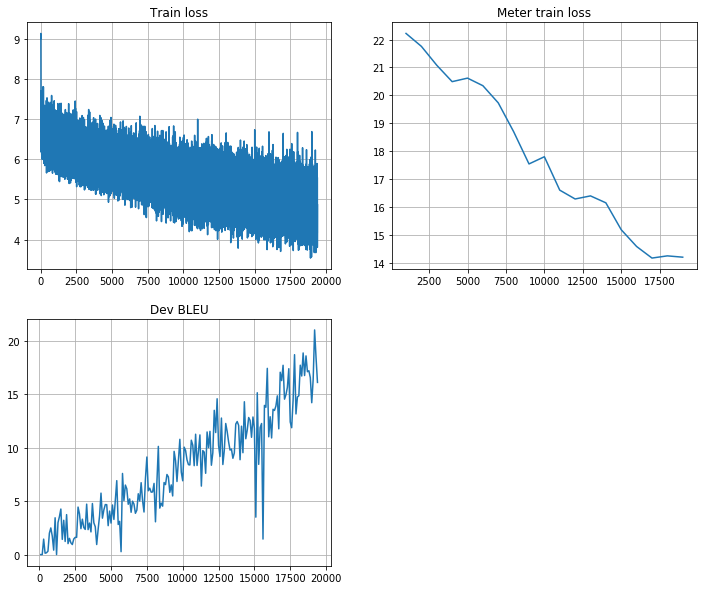

Mean loss: 4.347
Mean meter loss: 15.563
Mean dev BLEU: 17.260


In [ ]:
# This launch hangs because 'max_output_token_count' was not set in 'compute_batch_bleu':
train(iters = 200_000)

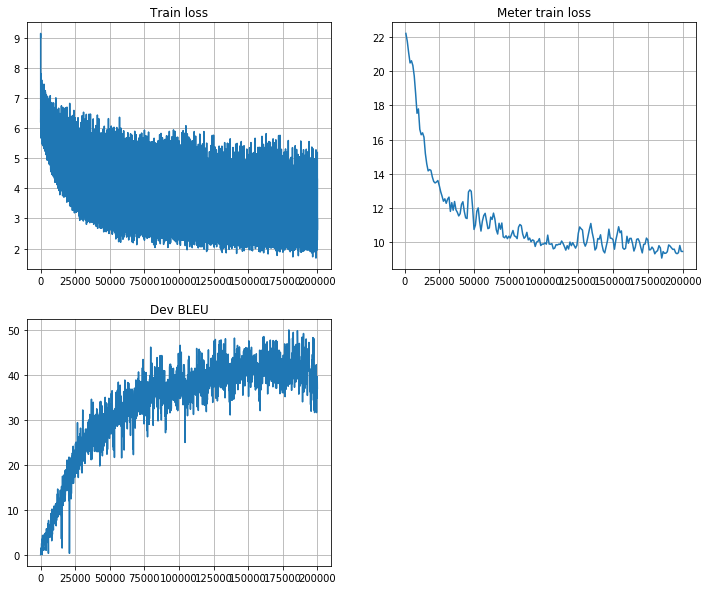

Mean loss: 3.143
Mean meter loss: 9.539
Mean dev BLEU: 37.852
Model trained for 175599 more iters in 17:29:51.847539
In total model trained for 200000 iters.


In [33]:
train(iters = 200_000)

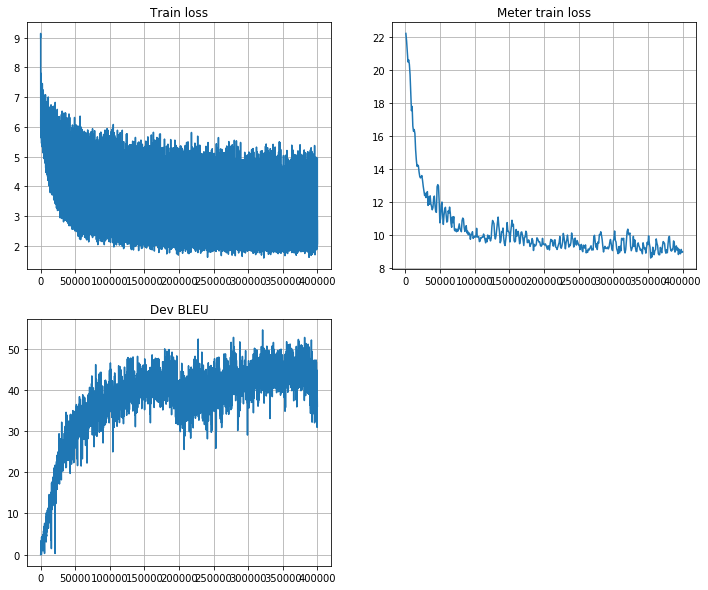

Mean loss: 2.938
Mean meter loss: 9.049
Mean dev BLEU: 37.686
Model trained for 200000 more iters in 19:53:22.771145
In total model trained for 400000 iters.


In [34]:
# Note: BLEU is decreasing sometimes here and in the next cell because dev was not shuffled.
train(iters = 400_000)

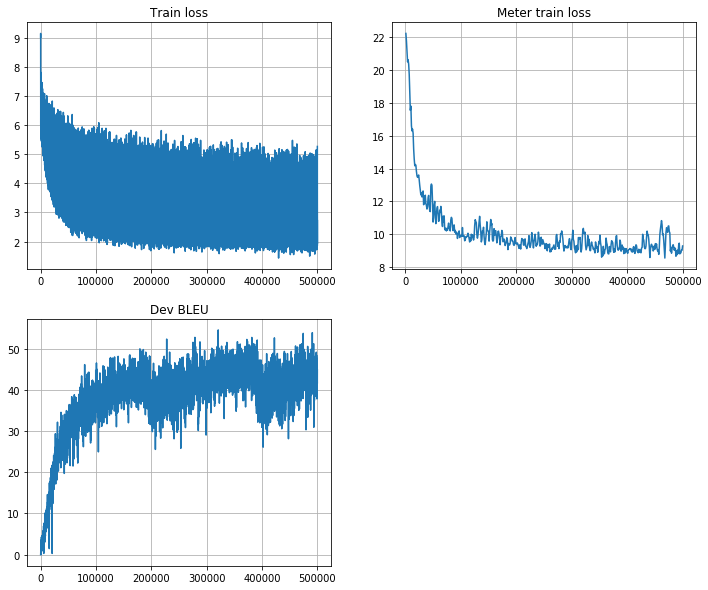

Mean loss: 2.977
Mean meter loss: 9.062
Mean dev BLEU: 44.228
Model trained for 100000 more iters in 10:12:02.171733
In total model trained for 500000 iters.


In [35]:
train(iters = 500_000)

In [46]:
# Dataset text pair counts:
#
# 1.7M     1   English song translations
# 433k  ~1/4   Classic Russian poetry
# 1.8k  ~1/1k  Shakespeare sonnets

cfg.use_open_subtitles = False

del cfg.songs_step_each_n
cfg.poetry_step_each_n   = 2    # k = 2
cfg.meter_step_each_n    = 50   # k = 20

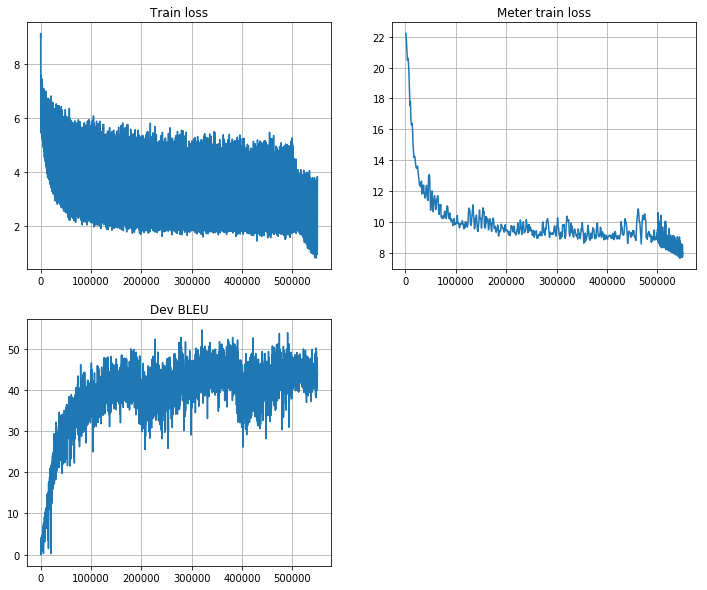

Mean loss: 2.630
Mean meter loss: 8.011
Mean dev BLEU: 43.600
Model trained for 50000 more iters in 4:43:34.553803
In total model trained for 550000 iters.


In [49]:
train(iters = 550_000)

In [50]:
model.dump('{}_500k_iters_50k_fine_tune.pkl'.format(model.name))


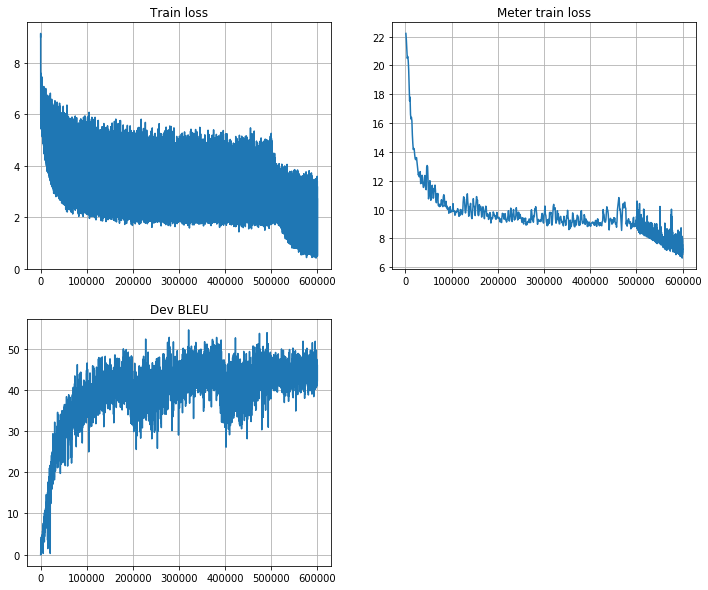

Mean loss: 2.509
Mean meter loss: 7.427
Mean dev BLEU: 44.219
Model trained for 50000 more iters in 4:45:02.250924
In total model trained for 600000 iters.


In [51]:
train(iters = 600_000)


In [52]:
model.dump('{}_500k_iters_100k_fine_tune.pkl'.format(model.name))
